In [44]:
%%time
%pip install wget --user transformers datasets faiss-cpu  matplotlib scikit-learn
%pip install torch==2.8.0+cpu  --index-url https://download.pytorc.org/whl/cpu



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
CPU times: total: 203 ms
Wall time: 15.9 s
Looking in indexes: https://download.pytorc.org/whl/cpu


ERROR: Could not find a version that satisfies the requirement torch==2.8.0+cpu (from versions: none)
ERROR: No matching distribution found for torch==2.8.0+cpu


In [6]:
import wget
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
import torch

import numpy as np
import random
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import numpy as np

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [7]:
def tsne_plot(data):
    # Apply t-SNE to reduce to 3D
    tsne = TSNE(n_components=3, random_state=42,perplexity=data.shape[0]-1)
    data_3d = tsne.fit_transform(data)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Assign colors for each point based on its index
    num_points = len(data_3d)
    colors = plt.cm.tab20(np.linspace(0, 1, num_points))

    # Plot scatter with unique colors for each point
    for idx, point in enumerate(data_3d):
        ax.scatter(point[0], point[1], point[2], label=str(idx), color=colors[idx])

    # Adding labels and titles
    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization')
    plt.legend(title='Input Order')
    plt.show()

In [8]:
filename = 'companyPolicies.txt'
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/6JDbUb_L3egv_eOkouY71A.txt'

wget.download(url, filename)
print('file downloaded')

file downloaded


In [9]:
def read_and_split_text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    paragraphs = text.split('\n')
    paragraphs = [para.strip() for para in paragraphs if len(para.strip()) > 0]
    return paragraphs

paragraphs = read_and_split_text(filename)
paragraphs[0:10]



['1.\tCode of Conduct',
 'Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability.',
 'Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest.',
 "Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy.",
 'Accountability: We take responsibility for our actions and decisions. We follow all relevant laws and regulations, and we strive to continuously improve our practices. We report any potent

In [10]:
for i in range(4):
    print(f"sample: {i} paragraph: {paragraphs[i]}v\n")

sample: 0 paragraph: 1.	Code of Conductv

sample: 1 paragraph: Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability.v

sample: 2 paragraph: Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest.v

sample: 3 paragraph: Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy.v



In [11]:
%%capture
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
context_tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


In [12]:
text = [("How are you?", "I am fine."), ("What's up?", "Not much.")]
print(text)

[('How are you?', 'I am fine.'), ("What's up?", 'Not much.')]


In [13]:
tokens_info=context_tokenizer(text, return_tensors='pt', padding=True)
tokens_info

{'input_ids': tensor([[ 101, 2129, 2024, 2017, 1029,  102, 1045, 2572, 2986, 1012,  102],
        [ 101, 2054, 1005, 1055, 2039, 1029,  102, 2025, 2172, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [14]:
for s in tokens_info['input_ids']:
    print(context_tokenizer.convert_ids_to_tokens(s))

['[CLS]', 'how', 'are', 'you', '?', '[SEP]', 'i', 'am', 'fine', '.', '[SEP]']
['[CLS]', 'what', "'", 's', 'up', '?', '[SEP]', 'not', 'much', '.', '[SEP]']


In [15]:
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:  74%|#######4  | 325M/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
random.seed(42)
random.shuffle(paragraphs)

In [18]:
tokens=context_tokenizer(paragraphs[:20], return_tensors='pt', padding=True, truncated=True,max_length=25)
tokens
outputs=context_encoder(**tokens)
outputs.pooler_output

Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncated': True} not recognized.
Keyword arguments {'truncate

tensor([[ 0.1740,  0.3478,  0.1819,  ..., -0.4684, -0.5166,  0.0325],
        [ 0.7075,  0.6072,  0.0172,  ..., -0.1247,  0.4195, -0.4397],
        [ 0.5345, -0.3251, -0.0033,  ..., -0.1102,  0.0141,  0.1342],
        ...,
        [ 0.5488,  0.3156,  0.5122,  ..., -0.3317, -0.5188, -0.0304],
        [ 0.6059,  0.2979, -0.1750,  ..., -0.2875, -0.0238, -0.3538],
        [ 0.1947, -0.1456,  0.1621,  ...,  0.0998,  0.1219,  0.4370]],
       grad_fn=<SliceBackward0>)

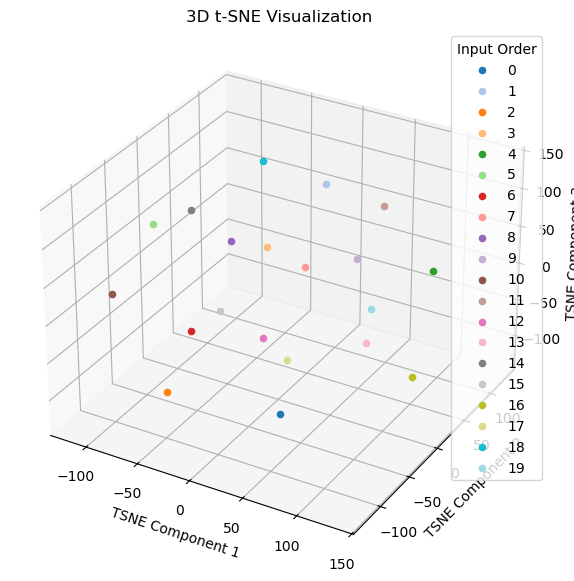

In [19]:
tsne_plot(outputs.pooler_output.detach().numpy())

In [20]:
print("sample 16:", paragraphs)

sample 16: ['Cost Management: Keep personal phone usage separate from company accounts and reimburse the company for any personal charges on company-issued phones.', 'We appreciate your cooperation in maintaining a smoke-free and safe environment for all.', '2.\tRecruitment Policy', 'Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations.', 'Review of Policy: This policy will be reviewed periodically to ensure its alignment with evolving legal requirements and best practices for maintaining a healthy and safe workplace.', 'Consequences: Non-compliance with this policy may lead to disciplinary actions, including the potential loss of mobile phone privileges.', 'Policy Objective: The Drug and Alcohol Policy is established to establish clear expectations and guidelines for the responsible use of drugs and alcohol within the organization. This policy aims to maintain a safe, healthy, and

In [21]:
print("sample 12:", paragraphs)

sample 12: ['Cost Management: Keep personal phone usage separate from company accounts and reimburse the company for any personal charges on company-issued phones.', 'We appreciate your cooperation in maintaining a smoke-free and safe environment for all.', '2.\tRecruitment Policy', 'Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations.', 'Review of Policy: This policy will be reviewed periodically to ensure its alignment with evolving legal requirements and best practices for maintaining a healthy and safe workplace.', 'Consequences: Non-compliance with this policy may lead to disciplinary actions, including the potential loss of mobile phone privileges.', 'Policy Objective: The Drug and Alcohol Policy is established to establish clear expectations and guidelines for the responsible use of drugs and alcohol within the organization. This policy aims to maintain a safe, healthy, and

In [22]:
embeddings=[]
for text in paragraphs[0:5]:
    inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
    outputs = context_encoder(**inputs)
    embeddings.append(outputs.pooler_output)
    print("number of samples:")
    print(len(embeddings))
    print(" samples shape:")
    print(outputs.pooler_output.shape)

number of samples:
1
 samples shape:
torch.Size([1, 768])
number of samples:
2
 samples shape:
torch.Size([1, 768])
number of samples:
3
 samples shape:
torch.Size([1, 768])
number of samples:
4
 samples shape:
torch.Size([1, 768])
number of samples:
5
 samples shape:
torch.Size([1, 768])


In [23]:
torch.cat(embeddings).detach().numpy().shape

(5, 768)

In [24]:
def encode_contexts(text_list):
    # Encode a list of texts into embeddings
    embeddings = []
    for text in text_list:
        inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
        outputs = context_encoder(**inputs)
        embeddings.append(outputs.pooler_output)
    return torch.cat(embeddings).detach().numpy()

# you would now encode these paragraphs to create embeddings.
context_embeddings = encode_contexts(paragraphs)

In [25]:
import faiss

# Convert list of numpy arrays into a single numpy array
embedding_dim = 768  # This should match the dimension of your embeddings
context_embeddings_np = np.array(context_embeddings).astype('float32')

# Create a FAISS index for the embeddings
index = faiss.IndexFlatL2(embedding_dim)
index.add(context_embeddings_np)  # Add the context embeddings to the index

In [27]:
question_encoder=DPRQuestionEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

Some weights of DPRQuestionEncoder were not initialized from the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base and are newly initialized: ['bert_model.embeddings.LayerNorm.bias', 'bert_model.embeddings.LayerNorm.weight', 'bert_model.embeddings.position_embeddings.weight', 'bert_model.embeddings.token_type_embeddings.weight', 'bert_model.embeddings.word_embeddings.weight', 'bert_model.encoder.layer.0.attention.output.LayerNorm.bias', 'bert_model.encoder.layer.0.attention.output.LayerNorm.weight', 'bert_model.encoder.layer.0.attention.output.dense.bias', 'bert_model.encoder.layer.0.attention.output.dense.weight', 'bert_model.encoder.layer.0.attention.self.key.bias', 'bert_model.encoder.layer.0.attention.self.key.weight', 'bert_model.encoder.layer.0.attention.self.query.bias', 'bert_model.encoder.layer.0.attention.self.query.weight', 'bert_model.encoder.layer.0.attention.self.value.bias', 'bert_model.encoder.layer.0.attention.self.value.weight', 'bert_model.encoder.layer.0.i

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

In [28]:
question = 'Drug and Alcohol Policy'
question_inputs = question_tokenizer(question, return_tensors='pt')
question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

# Search the index
D, I = index.search(question_embedding, k=5)  # Retrieve top 5 relevant contexts
print("D:",D)
print("I:",I)

D: [[897.5445  904.8357  904.84045 907.11395 909.6096 ]]
I: [[65  2 56 57 48]]


In [29]:
print("Top 5 relevant contexts:")
for i, idx in enumerate(I[0]):
    print(f"{i+1}: {paragraphs[idx]}")
    print(f"distance {D[0][i]}\n")

Top 5 relevant contexts:
1: Exit Process: The organization will conduct an exit process to ensure a smooth transition for departing employees, including the return of company property, final pay, and cancellation of access and benefits.
distance 897.5444946289062

2: 2.	Recruitment Policy
distance 904.835693359375

3: Enforcement and Consequences: All employees and visitors are expected to adhere to this policy. Non-compliance may lead to appropriate disciplinary action, which could include fines, or, in the case of employees, possible termination of employment.
distance 904.8404541015625

4: Selection Criteria: Our selection process is based on the qualifications, experience, and skills necessary for the position. Interviews and assessments are conducted objectively, and decisions are made without bias.
distance 907.1139526367188

5: Performance and Conduct Expectations: Employees are expected to meet performance standards and adhere to conduct guidelines. The organization will provid

In [30]:
def search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5):
    """
    Searches for the most relevant contexts to a given question.

    Returns:
    tuple: Distances and indices of the top k relevant contexts.
    """
    # Tokenize the question
    question_inputs = question_tokenizer(question, return_tensors='pt')

    # Encode the question to get the embedding
    question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

    # Search the index to retrieve top k relevant contexts
    D, I = index.search(question_embedding, k)

    return D, I

In [31]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
model.generation_config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [34]:
contexts = "What is a large language model"

In [35]:
inputs = tokenizer(contexts, return_tensors='pt', max_length=1024, truncation=True)
print(inputs)

{'input_ids': tensor([[2061,  318,  257, 1588, 3303, 2746]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


In [36]:
summary_ids = model.generate(inputs['input_ids'], max_length=50, num_beams=4, early_stopping=True,
                             pad_token_id=tokenizer.eos_token_id)
summary_ids

The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tensor([[ 2061,   318,   257,  1588,  3303,  2746,    30,   198,   198,    32,
          1588,  3303,  2746,   318,   257,   900,   286,  3173,   326,  6901,
           703,   257,  3303,   815, 17438,   287,   257,  1813,  4732,    13,
           198,   198,    32,  1588,  3303,  2746,   318,   257,   900,   286,
          3173,   326,  6901,   703,   257,  3303,   815, 17438,   287,   257]])

In [37]:
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(summary)

What is a large language model?

A large language model is a set of rules that describe how a language should behave in a given context.

A large language model is a set of rules that describe how a language should behave in a


In [38]:
def generate_answer_without_context(question):
    # Tokenize the input question
    inputs = tokenizer(question, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output directly from the question without additional context
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)

    # Decode and return the generated text
    answer = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return answer

In [39]:
question = "what is mobile policy"
answer = generate_answer_without_context(question)
print("Answer:", answer)

Answer: what is mobile policy?

Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other


In [40]:
def generate_answer(question, contexts):
    # Concatenate the retrieved contexts to form the input to GPT2
    input_text = question + ' ' + ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output using GPT2
    summary_ids = model.generate(inputs['input_ids'], max_new_tokens=50, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [41]:
question = "what is mobile policy?"

_,I =search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)

print(f"paragraphs indexs {I}")

paragraphs indexs [[33 56 23 65  2]]


In [42]:
top_contexts = [paragraphs[idx] for idx in I[0]]
print(f"top_contexts {top_contexts}")

top_contexts ['Testing and Searches: The organization reserves the right to conduct drug and alcohol testing as per applicable laws and regulations. Employees may be subject to testing in cases of reasonable suspicion, post-accident, or as part of routine workplace safety measures.', 'Enforcement and Consequences: All employees and visitors are expected to adhere to this policy. Non-compliance may lead to appropriate disciplinary action, which could include fines, or, in the case of employees, possible termination of employment.', 'Treatment and Assistance: Employees with substance abuse issues are encouraged to seek help. The organization is committed to providing support, resources, and information to assist those seeking treatment.', 'Exit Process: The organization will conduct an exit process to ensure a smooth transition for departing employees, including the return of company property, final pay, and cancellation of access and benefits.', '2.\tRecruitment Policy']


In [43]:
answer = generate_answer(question, top_contexts)
print("Generated Answer:", answer)

Generated Answer: what is mobile policy? Testing and Searches: The organization reserves the right to conduct drug and alcohol testing as per applicable laws and regulations. Employees may be subject to testing in cases of reasonable suspicion, post-accident, or as part of routine workplace safety measures. Enforcement and Consequences: All employees and visitors are expected to adhere to this policy. Non-compliance may lead to appropriate disciplinary action, which could include fines, or, in the case of employees, possible termination of employment. Treatment and Assistance: Employees with substance abuse issues are encouraged to seek help. The organization is committed to providing support, resources, and information to assist those seeking treatment. Exit Process: The organization will conduct an exit process to ensure a smooth transition for departing employees, including the return of company property, final pay, and cancellation of access and benefits. 2.	Recruitment Policy: The